# 02.21.01 - DNN MFCC20 (4-Fold) SOFTMAX

## Goals

In this experiment, we intend to assess the generalization capability of a Dense Neural Network using MFCC coeffecicients as features, through a 4-folds cross validation over the hive axis.

In reality, due to the fact that some hives in the reference dataset only present one label value (either queen of noqueen) a fold may be an agregate of 2 distincts hives, but in any case, for each fold, the network is tested over samples belonging to hive(s) it was never trained on. 

Distribution details are provided below:

<table border="1" class="dataframe" align="left">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>fold</th>
      <th>hive</th>
      <th>queen</th>
      <th>count(*)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>1</td>
      <td>CF001</td>
      <td>0.0</td>
      <td>14</td>
    </tr>
    <tr>
      <th>1</th>
      <td>1</td>
      <td>CF003</td>
      <td>1.0</td>
      <td>3649</td>
    </tr>
    <tr>
      <th>2</th>
      <td>2</td>
      <td>CJ001</td>
      <td>0.0</td>
      <td>790</td>
    </tr>
    <tr>
      <th>3</th>
      <td>2</td>
      <td>GH001</td>
      <td>1.0</td>
      <td>1396</td>
    </tr>
    <tr>
      <th>4</th>
      <td>3</td>
      <td>Hive1</td>
      <td>0.0</td>
      <td>1473</td>
    </tr>
    <tr>
      <th>5</th>
      <td>3</td>
      <td>Hive1</td>
      <td>1.0</td>
      <td>2684</td>
    </tr>
    <tr>
      <th>6</th>
      <td>4</td>
      <td>Hive3</td>
      <td>0.0</td>
      <td>6545</td>
    </tr>
    <tr>
      <th>7</th>
      <td>4</td>
      <td>Hive3</td>
      <td>1.0</td>
      <td>654</td>
    </tr>
  </tbody>
</table>
<br><br><br><br><br><br><br><br><br><br><br><br><br>



The network demonstrates extremely poor generalization, regardless of the topology or hyper-parameters we have tested so far.


## Prerequisites

- The dataset exists (if not, execute 02.00)
- The dataset features have been populated (if not, execute 02.01)


<hr style="border:1px solid gray"></hr>

### Step 1: Get previously created dataset

In [1]:
import warnings                      # This block prevents display of harmless warnings, but should be
warnings.filterwarnings('ignore')    # commented out till the experiment final version,
                                     # in order to avoid missing "real" warnings 

import kilroy_was_here               # Mandatory. Allow access to shared python code from repository root
from audace.jupytools import (
    iprint,                          # timestamped (to the ms) print with CPU and RAM consumption information  
    predestination,                  # Seeds various PRNGs for reproducibility
    say_my_name                      # gets notebook name
)

from audace.audiodataset import AudioDataset      # Main class for audio dataset handling

#########################
# Experiment parameters #
#########################

EXP_NAME = say_my_name()  # Experiment name will be used to create outputs directory

DATASET_NAME = 'MAIN1000' # Dataset name is the master key for dataset addressing
                          # Change it according to the dataset you want to process

FEATURE_NAME = 'mfcc20'   # Name of the feature used for classification
LABEL_NAME = 'queen'      # Name of the label used for classification
FOLD_NAME = 'fold'        # Column nam of the fold axis
VALID_FRAC = 0.3          # Fraction of the training set used for validation (NOT TESTING)
                          # This is used to drive early stopping. Hyperparameters may be tuned
                          # over the validation set, but the test set is kept isolated to avoid biases.


# Initialize Dataset Object. 
ds = AudioDataset(DATASET_NAME)
    
# Display AudioDataset summary    
ds.info()

# Build dataframe containing all the information needed to conduct the experiment
sql = F"SELECT {FEATURE_NAME}, {LABEL_NAME}, {FOLD_NAME} FROM samples WHERE nobee = 0"
df = ds.queryDataFrame(sql)

# Display cardinalities
sql = """
    select distinct fold, hive, queen, count(*)
    from samples
    where nobee = 0
    group by fold, queen
    order by fold, queen
    """
ds.queryDataFrame(sql)

[2020-09-04/16:44:58.191|21.6%|83.7%|0.28GB] ------------------------------------------------------
[2020-09-04/16:44:58.192|00.0%|83.7%|0.28GB] DATASET NAME          : MAIN1000
[2020-09-04/16:44:58.193|00.0%|83.7%|0.28GB] DATASET PATH          : D:\Jupyter\ShowBees\datasets\MAIN1000
[2020-09-04/16:44:58.194|00.0%|83.7%|0.28GB] DATASET DB PATH       : D:\Jupyter\ShowBees\datasets\MAIN1000\MAIN1000.db
[2020-09-04/16:44:58.194|00.0%|83.7%|0.28GB] DATASET SAMPLES PATH  : D:\Jupyter\ShowBees\datasets\MAIN1000\samples
[2020-09-04/16:44:58.194|00.0%|83.7%|0.28GB] NB SOURCE AUDIO FILES : 48
[2020-09-04/16:44:58.196|00.0%|83.7%|0.28GB] SAMPLE RATE           : 22050
[2020-09-04/16:44:58.197|00.0%|83.8%|0.28GB] DURATION              : 1.0
[2020-09-04/16:44:58.197|00.0%|83.8%|0.28GB] OVERLAP               : 0.0
[2020-09-04/16:44:58.198|00.0%|83.8%|0.28GB] NB AUDIO CHUNKS       : 24788
[2020-09-04/16:44:58.199|00.0%|83.8%|0.28GB] ------------------------------------------------------


,fold,hive,queen,count(*)
0,1,CF001,0.0,14
1,1,CF003,1.0,3649
2,2,CJ001,0.0,790
3,2,GH001,1.0,1396
4,3,Hive1,0.0,1473
5,3,Hive1,1.0,2684
6,4,Hive3,0.0,6545
7,4,Hive3,1.0,654


In [2]:
ds.listFeatures()

['api180_185_1',
 'api180_190_5',
 'api180_225_1',
 'apidictor',
 'emph_mfcc20',
 'jpg00',
 'mfcc20',
 'mfcc8',
 'std_apidictor',
 'std_mfcc20',
 'std_mfcc8',
 'stft128']

<hr style="border:1px solid gray"></hr>

### Step 2: Process DNN learning

In [3]:
from tensorflow import keras

def nn(n_inputs):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=n_inputs))
    model.add(keras.layers.Dense(4, activation="selu", kernel_initializer="lecun_normal"))
    model.add(keras.layers.Dense(4, activation="selu", kernel_initializer="lecun_normal"))
    model.add(keras.layers.Dense(2, activation="softmax"))

    model.compile(
        loss="categorical_crossentropy", optimizer="nadam",
        metrics=[
            "accuracy",
            "categorical_crossentropy"
        ]
    )    
    
    return model

In [7]:
from sklearn import svm, metrics
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from audace.splitters import splitTrainValidTestFold
from audace.metrics import i_may_be_wrong_categorical

# Seed the various PRNGs
predestination()

histories = []
# Iterate over folds
for fold in ds.listAttributeValues(FOLD_NAME):
    print(F"############### FOLD {fold} ###############")
    # Build training and test datasets
    iprint(">>>>> Building partitions training/test")
    X_train, X_valid, X_test, y_train, y_valid, y_test = splitTrainValidTestFold(
        df,
        FEATURE_NAME,
        LABEL_NAME,
        FOLD_NAME,
        fold,
        VALID_FRAC
    )
    
    
    print(y_test.shape)
    
    # Standardize data 
    iprint(">>>>> Standardize")
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    X_test = scaler.transform(X_test)
    
    # One Hot encode scalar label
    iprint(">>>>>> Encode")
    ohe = OneHotEncoder(sparse=False)
    y_train = ohe.fit_transform(y_train)
    y_valid = ohe.transform(y_valid)
    y_test = ohe.transform(y_test)    

    # Build NN
    iprint(">>>>> Build NN")
    keras.backend.clear_session()
    model = nn(X_train[0].shape)

    iprint(F">>>>> Train on {len(X_train)}, valid on {len(X_valid)}, test on {len(X_test)}")
    
    early_stopping_cb = keras.callbacks.EarlyStopping(
                            monitor='val_categorical_crossentropy',
                            patience=10,
                            restore_best_weights=True
                        )
    
    history = model.fit(X_train,
                        y_train,
                        validation_data=(X_valid, y_valid),
                        epochs=100,
                        callbacks=[early_stopping_cb],
                        verbose=2
    )
    
    histories.append(history)
    
    
    iprint('>>>>> Predict')
    scores = model.evaluate(X_test, y_test, verbose=0)

    for i in range(len(scores)):
        iprint(F"{model.metrics_names[i]}: {scores[i]}")
        
    ans, acc = i_may_be_wrong_categorical(model, X_test, y_test, 0.99)
    iprint(F"ans: {round(ans,5)} / acc: {round(acc,5)}")  


############### FOLD 1 ###############
[2020-09-04/16:46:47.059|08.5%|93.5%|0.56GB] >>>>> Building partitions training/test
(3663, 1)
[2020-09-04/16:46:47.158|22.2%|94.1%|0.61GB] >>>>> Standardize
[2020-09-04/16:46:47.396|17.5%|94.2%|0.61GB] >>>>>> Encode
[2020-09-04/16:46:47.399|00.0%|94.2%|0.61GB] >>>>> Build NN
[2020-09-04/16:46:47.471|25.0%|94.2%|0.61GB] >>>>> Train on 9479, valid on 4063, test on 3663
Train on 9479 samples, validate on 4063 samples
Epoch 1/100
9479/9479 - 2s - loss: 0.1375 - accuracy: 0.9520 - categorical_crossentropy: 0.1375 - val_loss: 0.0420 - val_accuracy: 0.9897 - val_categorical_crossentropy: 0.0420
Epoch 2/100
9479/9479 - 0s - loss: 0.0275 - accuracy: 0.9931 - categorical_crossentropy: 0.0275 - val_loss: 0.0261 - val_accuracy: 0.9926 - val_categorical_crossentropy: 0.0261
Epoch 3/100
9479/9479 - 1s - loss: 0.0150 - accuracy: 0.9967 - categorical_crossentropy: 0.0150 - val_loss: 0.0228 - val_accuracy: 0.9936 - val_categorical_crossentropy: 0.0228
Epoch 4/100

Epoch 3/100
9133/9133 - 0s - loss: 0.0054 - accuracy: 0.9990 - categorical_crossentropy: 0.0054 - val_loss: 0.0140 - val_accuracy: 0.9949 - val_categorical_crossentropy: 0.0140
Epoch 4/100
9133/9133 - 1s - loss: 0.0018 - accuracy: 0.9999 - categorical_crossentropy: 0.0018 - val_loss: 0.0120 - val_accuracy: 0.9959 - val_categorical_crossentropy: 0.0120
Epoch 5/100
9133/9133 - 1s - loss: 9.5053e-04 - accuracy: 1.0000 - categorical_crossentropy: 9.5053e-04 - val_loss: 0.0144 - val_accuracy: 0.9946 - val_categorical_crossentropy: 0.0144
Epoch 6/100
9133/9133 - 1s - loss: 6.5616e-04 - accuracy: 1.0000 - categorical_crossentropy: 6.5616e-04 - val_loss: 0.0123 - val_accuracy: 0.9959 - val_categorical_crossentropy: 0.0123
Epoch 7/100
9133/9133 - 0s - loss: 3.7311e-04 - accuracy: 1.0000 - categorical_crossentropy: 3.7311e-04 - val_loss: 0.0124 - val_accuracy: 0.9964 - val_categorical_crossentropy: 0.0124
Epoch 8/100
9133/9133 - 0s - loss: 2.7090e-04 - accuracy: 1.0000 - categorical_crossentropy

<hr style="border:1px solid gray"></hr>

### Step 3: Display learning report

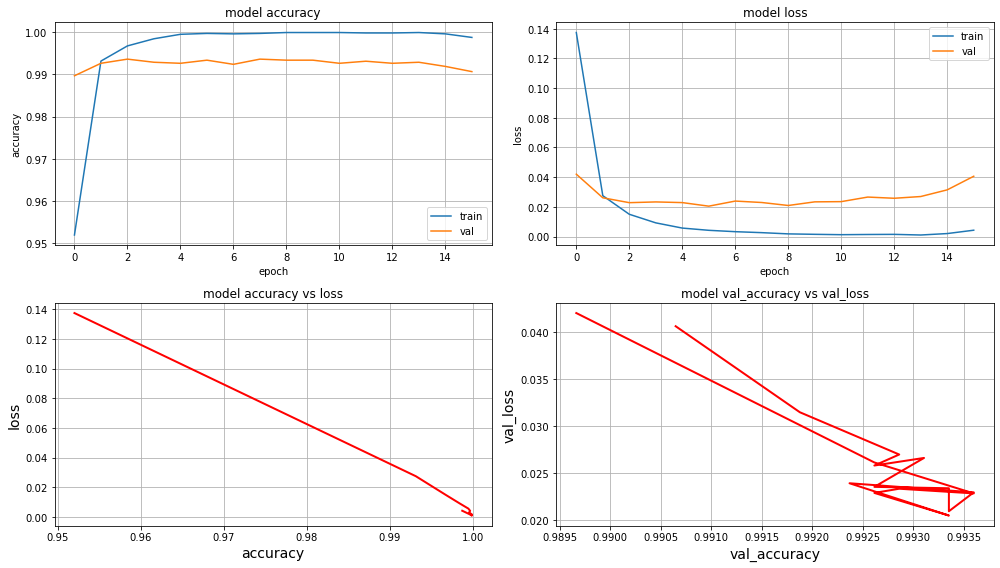

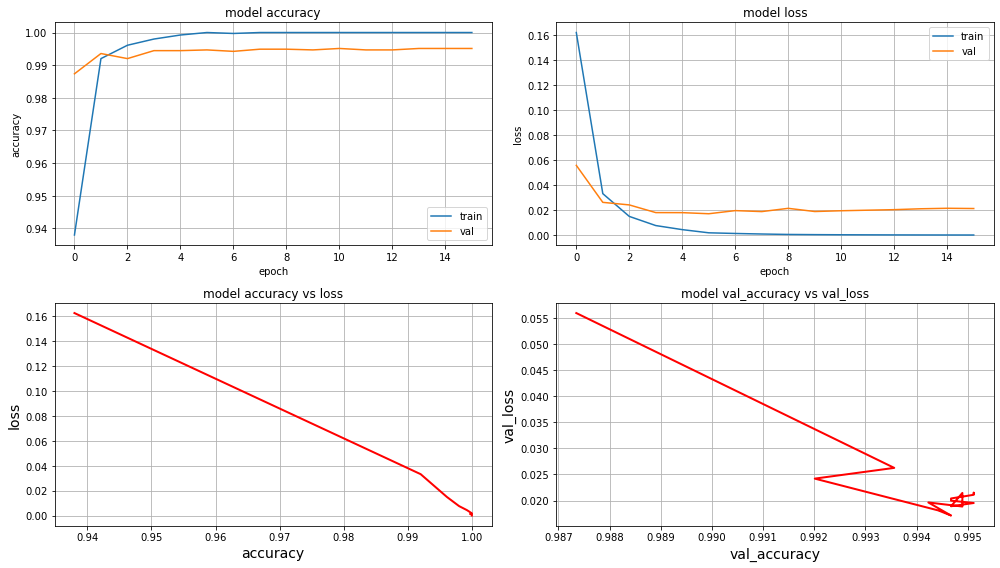

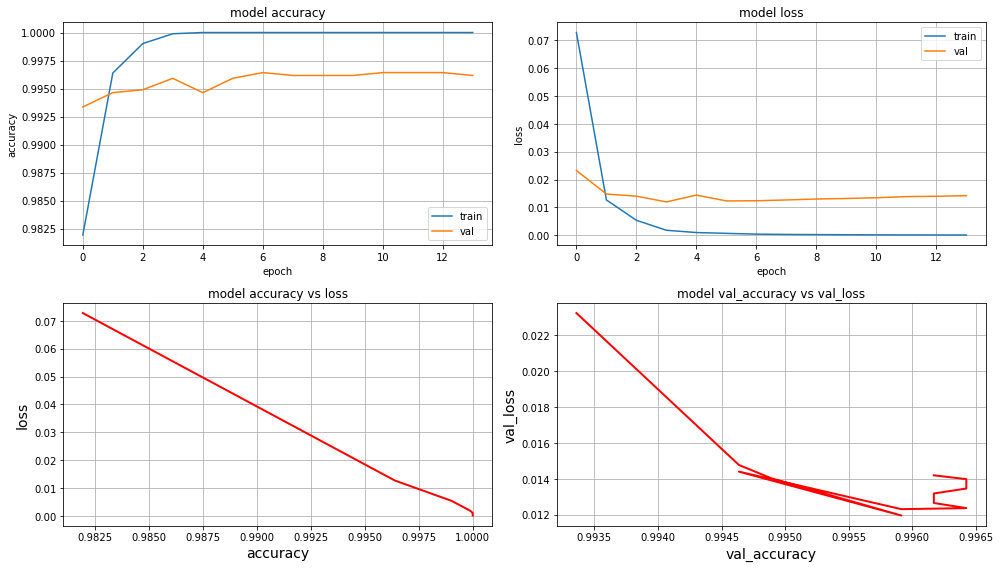

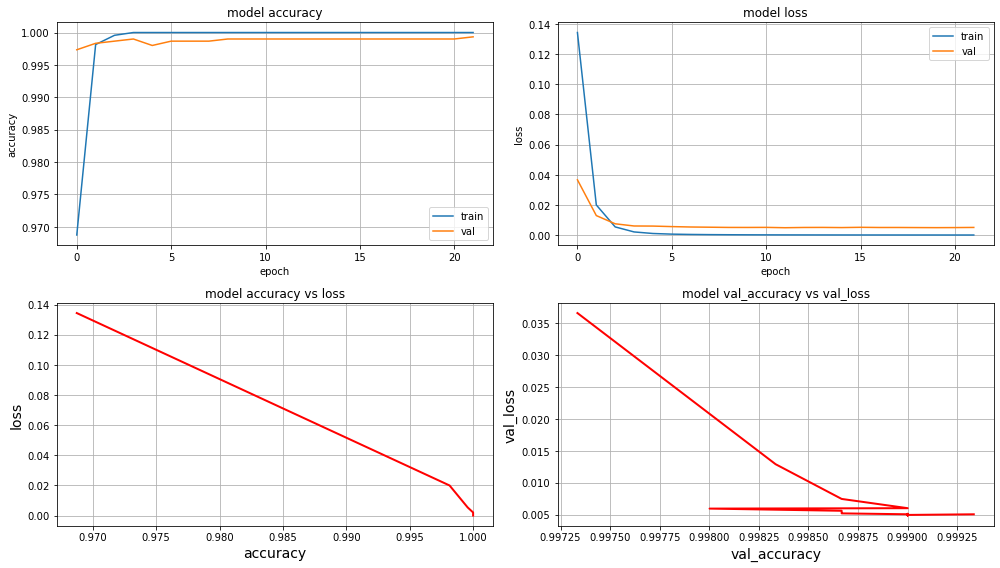

In [5]:
from audace.plotters import plot_nn_learning_curves

for fold in ds.listAttributeValues(FOLD_NAME):
    plot_nn_learning_curves(histories[fold-1], EXP_NAME, 'learning report fold ' + str(fold))

<hr style="border:1px solid gray"></hr>

### Step 4 : Display performance reports

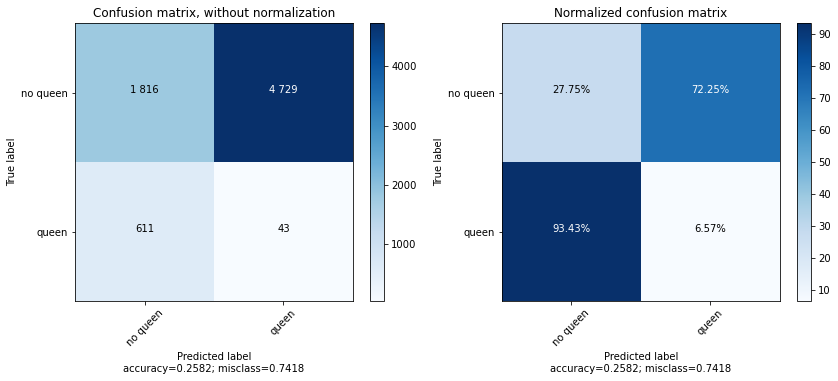

[2020-09-04/16:45:44.134|21.2%|92.1%|0.56GB] >>>>> Predict
[2020-09-04/16:45:44.301|14.6%|92.1%|0.56GB] loss: 15.424129884033373
[2020-09-04/16:45:44.302|00.0%|92.1%|0.56GB] accuracy: 0.2582302987575531
[2020-09-04/16:45:44.302|00.0%|92.1%|0.56GB] categorical_crossentropy: 15.424128532409668


In [6]:
from audace.plotters import nn_full_report

nn_full_report(model, X_test, y_test, target_names = ['no queen', 'queen'])


#Predict the response for test dataset
iprint('>>>>> Predict')
scores = model.evaluate(X_test, y_test, verbose=0)

for i in range(len(scores)):
    iprint(F"{model.metrics_names[i]}: {scores[i]}")